# Measuring and modelling the HI power spectrum multipoles

This script demonstrates an overview of the `runMainMultipoles.py` script, namely how to calculate the HI power spectrum monopole and quadrupole and how to model it.

In [1]:
# importing necessary packages:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# adding path to MultipoleExpansion directory in order to import relevant scripts
import sys
sys.path.append('../')

# importing relevant scripts:
import cosmotools
import mpl_style
plt.style.use(mpl_style.style1)
cosmotools.SetCosmology('Planck15')
import pktools
import teletools
import modellingtools
import stattools


Selected Cosmology: FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486) 



## Select redshift

$z = 2.03$ or $z=0.82$

In [2]:
#zeff = 2.03 #Redshift for simulation box
zeff = 0.82 #Redshift for simulation box

# survey & cosmological parameters for modelling:

H_0 = cosmotools.H(0)
h = H_0 / 100
Tbar = teletools.TbarModel(zeff) #mK
d_c = cosmotools.D_com(zeff)
if zeff==0.82:
    b_HI = 1.15
    P_SN = Tbar**2*124 #From https://arxiv.org/pdf/1804.09180.pdf (Table 5)
    theta_FWHM,R_beam = teletools.getbeampars(zeff,d_c)
    sig_v = 250*h
if zeff==2.03:
    b_HI = 1.95
    P_SN = Tbar**2*65 #From https://arxiv.org/pdf/1804.09180.pdf (Table 5)
    theta_FWHM,R_beam = teletools.getbeampars(zeff,d_c)
    sig_v = 0
ffid = cosmotools.f(zeff)
B = ffid / b_HI


Telescope Params: Dish size = 100 m, R_beam = 3.9 Mpc/h, theta_FWHM = 0.27 deg



## Measuring the power spectrum

The below outlines how to calculate the HI power spectrum for the monopole and quadrupole, using MultiDark simulations.

In [3]:
# Dimension of data cube:
lx,ly,lz = 1000,1000,1000 #Mpc/h
nx,ny,nz = 225,225,225
lzbuff = 119 #Used to achieve a lz=762Mpc/h which is ~Deltaz=0.4 at zeff=0.8
xbins = np.linspace(0,lx,nx+1) #cartesian-z pixel bins
ybins = np.linspace(0,ly,ny+1) #cartesian-z pixel bins
lz = lz - 2*lzbuff

In [4]:
# Read-in and Process HI maps
dT_HI = np.load('../MultiDarkSims/dT_HI-MDSAGE_z_%s.npy'%zeff)
xbincentres = xbins+(xbins[1]-xbins[0])/2
xbincentres = xbincentres[:len(xbincentres)-1] #remove last value since this is outside of bins
ybincentres = ybins+(ybins[1]-ybins[0])/2
ybincentres = ybincentres[:len(ybincentres)-1] #remove last value since this is outside of bins
for i in range(nz):
    dT_HI[:,:,i] = teletools.smoothimage(dT_HI[:,:,i],0,0,lx,ly,xbincentres,ybincentres,R_beam)
dv = 1e6 #Hz (1MHz freq bin width) - use for noise map
dT_noise1,sigma_N = teletools.ReceiverNoise(zeff,dv,d_c,nx,ny,nz,lx,ly,theta_FWHM)
dT_noise2,sigma_N = teletools.ReceiverNoise(zeff,dv,d_c,nx,ny,nz,lx,ly,theta_FWHM)
dT_HI1 = dT_HI + dT_noise1
dT_HI2 = dT_HI + dT_noise2

In [5]:
# Measure the auto-power spectrum
kmin,kmax = 0.02,0.3
nkbin = 29
dk = (kmax-kmin)/nkbin
k = np.linspace(kmin+0.5*dk,kmax-0.5*dk,nkbin)
pkspec = pktools.getpkspec(dT_HI1,dT_HI2,nx,ny,nz,lx,ly,lz,kmin,kmax,nkbin)
W = pktools.W_alias(nx,ny,nz,lx,ly,lz,p=1)
pkspec = pkspec/W**2  # Correct for aliasing
# perform multipole expansion on power spectrum:
pkmults, nmodes = pktools.binpole(pkspec,nx,ny,nz,lx,ly,lz,kmin,kmax,nkbin)

In [6]:
# obtain theory errors
vol_cell = lx*ly*lz / (nx*ny*nz)
P_N = sigma_N**2 * vol_cell
sig_pl = stattools.MultipoleError(P_N,pkmults[0],pkmults[1],pkmults[2],nmodes)

## Modelling the power spectrum

The below outlines how to calculate the model HI power spectrum for the monopole and quadrupole.

In [7]:
# underlying linear matter power spectrum
kmod,Pmod = np.load('../inputs/Pk_z=%s.npy'%zeff)

In [8]:
# damping function for beam:
def B_beam(mu,k,R_beam):
    return np.exp( -(1-mu**2)*k**2*R_beam**2/2 )
# Anisotropic power spectrum and Legendre polynomials:
def P(k,mu,b,B,sig_v,Pk_M,i):
    return b**2 * (1 + B*mu**2)**2 / (1 + (k*mu*sig_v/H_0)**2) * Pk_M[i]
def Leg0(mu):
    return 1
def Leg2(mu):
    return (3*mu**2 - 1) / 2

# modelling function:
def MultipoleExpansion(Pk_M,kmod,b,B,sig_v,P_SN,R_beam):
    #Define Parameters and multipoles:
    theta = np.radians( np.linspace(-180,180,10000) )
    mu = np.cos(theta)
    PL0 = lambda mu: 1/2 * P(k_i,mu,b,B,sig_v,Pk_M,i) * B_beam(mu,k_i,R_beam)**2 * Leg0(mu)
    PL2 = lambda mu: 5/2 * P(k_i,mu,b,B,sig_v,Pk_M,i) * B_beam(mu,k_i,R_beam)**2 * Leg2(mu)
    PSN0 = lambda mu: 1/2 * P_SN * B_beam(mu,k_i,R_beam)**2 * Leg0(mu)
    PSN2 = lambda mu: 5/2 * P_SN * B_beam(mu,k_i,R_beam)**2 * Leg2(mu)
    P_0 = np.zeros(len(kmod)); P_2 = np.zeros(len(kmod))
    PSN_0 = np.zeros(len(kmod)); PSN_2 = np.zeros(len(kmod))
    for i in range(len(kmod)):
        k_i = kmod[i]
        if k_i==0: k_i = 1e-30 #Avoid divide by k=0
        P_0[i] = integrate.quad(PL0, -1, 1)[0]
        P_2[i] = integrate.quad(PL2, -1, 1)[0]
        PSN_0[i] = integrate.quad(PSN0, -1, 1)[0]
        PSN_2[i] = integrate.quad(PSN2, -1, 1)[0]
    return P_0+PSN_0,P_2+PSN_2

In [13]:
# calculating power spectrum model:
pk0mod,pk2mod = MultipoleExpansion(Pmod,kmod,b_HI,B,sig_v,P_SN,R_beam)
pkmultsmods = [pk0mod,pk2mod]

#in the runMainMultipoles.py script this is done as below, and gives the same results as above!
#pk0mod,pk2mod,pk4mod = modellingtools.MultipoleExpansion(Pmod,kmod,b_HI,B,P_SN,R_beam,sig_v,doFG=False,noRSD=False)
#pkmultsmods = [pk0mod,pk2mod,pk4mod]

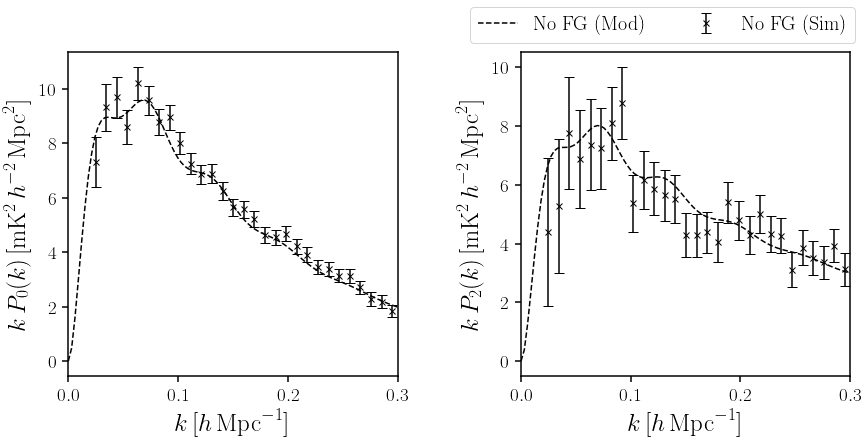

In [14]:
# plot multipoles

kmax = 0.3
fontsize = 25
plt.figure(figsize=(12,6))
for i in range(2):
    plt.subplot(121+i)
    # if including error:
    plt.errorbar(k, k*pkmults[i], yerr=k*sig_pl[i], fmt='x',capsize=5, markersize=6, label='No FG (Sim)',color='Black')
    plt.plot(kmod,kmod*Tbar**2*pkmultsmods[i],linestyle='dashed',color='Black',label='No FG (Mod)')
    plt.xticks([0,0.1,0.2,0.3])
    plt.xlabel(r'$k \, [h \, {\rm Mpc}^{-1}]$',fontsize=fontsize)
    plt.ylabel(r'$k \,P_{%s}(k) \, $[mK$^2\,h^{-2} \, {\rm Mpc}^2$]'%(i*2),fontsize=fontsize)
    plt.tick_params(labelsize=fontsize-2)
    if i==1: plt.legend(ncol=4,loc='upper center',bbox_to_anchor=[0.43, 1.17],fontsize=fontsize-5)
    plt.tick_params(labelsize=fontsize-6)
    plt.xlim(left=0,right=kmax)
plt.subplots_adjust(top=0.9,
bottom=0.15,
left=0.08,
right=0.985,
hspace=0.2,
wspace=0.375)
plt.show()